In [ ]:
# First preprocessing cut ROI from the image

> Cut only the ROI from the image

In [1]:
#| default_exp preprocessing.cut_roi

In [54]:
#| export
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import shutil
import os
from fastcore.all import *
import cv2

In [22]:
import matplotlib as mpl
mpl.rcParams['image.cmap']='gray'

In [17]:
#| export
from cv_tools.core import *

In [14]:
data_path = Path(os.getenv('DATA_PATH'), 'crack_detect_usm')
data_path.ls()

(#11) [Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig2.parquet'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig2'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig1'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good.parquet'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/models'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig4.parquet'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig3'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig1.parquet'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig4')...]

In [86]:

good_im_path = Path(data_path, 'good')
tst_im_path = Path(data_path, 'test_data_sig1')
tst_im2_path = Path(data_path, 'test_data_sig2')
tst_im3_path = Path(data_path, 'test_data_sig3')
tst_im4_path = Path(data_path, 'test_data_sig4')
tmp_sig1_path = Path(data_path, 'temp/sig1')
tmp_sig2_path = Path(data_path, 'temp/sig2')
tmp_sig3_path = Path(data_path, 'temp/sig3')
tmp_sig4_path = Path(data_path, 'temp/sig4')
tmp_sig1_path.mkdir(exist_ok=True, parents=True)
tmp_sig2_path.mkdir(exist_ok=True, parents=True)
tmp_sig3_path.mkdir(exist_ok=True, parents=True)
tmp_sig4_path.mkdir(exist_ok=True, parents=True)
good_im_path.ls(), tst_im_path.ls()

((#19106) [Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81834702_02_DCB-2932306405550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81705396_01_DCB-0712345182450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81756453_02_DCB-1482319866450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81707405_01_DCB-1312301164550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81720270_01_DCB-1582307722550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81759009_01_DCB-1532342654450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/DCB-1382387950450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/DCB-1312306704550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81759011_02_DCB-1612348130450663_a.png'),Path('/home/hasan/Schreibtisch/projects/d

True

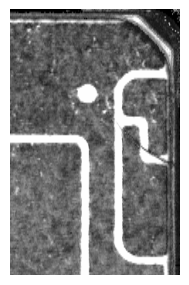

In [125]:
im4_img = read_img(Path(tst_im4_path).ls()[0])
show_(im4_img[55:400, 500:720])
cv2.imwrite(f'{tmp_sig4_path}/template.png', im4_img[55:400, 500:720])

In [126]:
#tmp_sig1 = 
tmp_sig1_img = read_img(Path(tmp_sig1_path).ls()[0])
tmp_sig2_img = read_img(Path(tmp_sig2_path).ls()[0])
tmp_sig3_img = read_img(Path(tmp_sig3_path).ls()[0])
tmp_sig4_img = read_img(Path(tmp_sig4_path).ls()[0])

In [127]:
tmp_sig1_img.shape, tmp_sig2_img.shape, tmp_sig3_img.shape, tmp_sig4_img.shape

((466, 310), (310, 240), (420, 220), (345, 220))

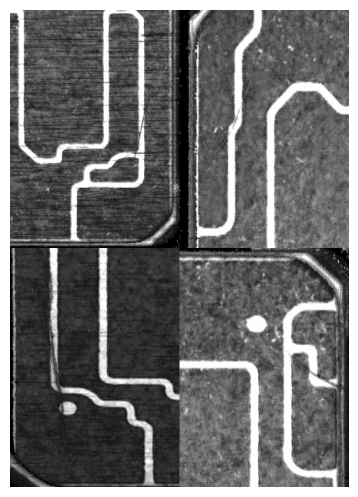

In [133]:
show_(concat_images([tmp_sig1_img, tmp_sig2_img, tmp_sig3_img, tmp_sig4_img], rows=2, cols=2, number='3'))

In [25]:
sm_img = tst_im_path.ls()[0]
img = read_img(sm_img)

# Testing one good image with template and roi

In [ ]:
def frm_full_img_to_roi_img(
        img: np.ndarray,
		
)

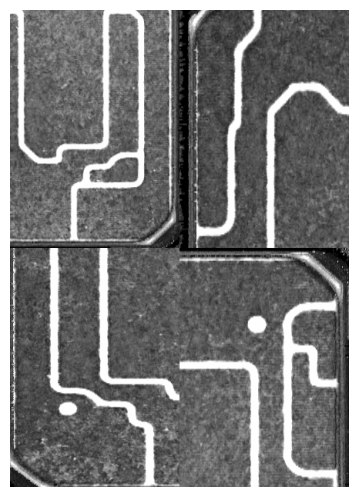

In [138]:
sm_img = read_img(good_im_path.ls()[0])
conc= []
for i in [tmp_sig1_img, tmp_sig2_img, tmp_sig3_img, tmp_sig4_img]:
	x, y, w, h = get_template_part(sm_img, i)
	tmp_img_ = sm_img[y:y+h, x:x+w]
	conc.append(tmp_img_)
nw_img = concat_images(conc, rows=2, cols=2, number='3')
show_(nw_img)